In [93]:
import tensorflow as tf
from tensorflow import keras as kr
from keras import layers
import pandas as pd
import numpy as np
import os
from env_paths import *
import matplotlib.pyplot as plt

In [94]:
INPUT_COLS = ["t_ext", "h_ext", "t_C_cal","h_C_cal","t_L_cal","h_L_cal"]
MIN_MAX_COLS_VALUES = {"t_ext": (-50, 50), "h_ext": (0, 100), "t_C_cal": (-50, 50), 
                       "t_L_cal": (-50, 50), "h_C_cal": (0, 100), "h_L_cal": (0, 100)}

In [95]:
files = os.listdir(CLASSIFIED_SENSOR_PATH)
df = pd.read_csv(CLASSIFIED_SENSOR_PATH + files[1])
df['ts'] = pd.to_datetime(df['ts'], unit="ns")

In [96]:
# Normalizacion de cada columna empleando (xi – minimo(x)) / (máximo(x) – minimo(x))
for col, (min, max) in MIN_MAX_COLS_VALUES.items():
    df[col]=(df[col]-min)/(max-min)

In [97]:
learning_rate = 0.005 # Ratio de aprendizaje
batch_size = 256 # Tamanno del conjunto de datos que se introducen en bloque en entrenamiento
epochs = 100 # Epocas de entrenamiento de la RNA
train_val_fraction = 0.8 # Fraccion de datos empleada en el conjunto de entrenamiento y validacion 

In [98]:

# Instanciacion del modelo, creacion de capas y declaracion de las neuronas por capas y su funcion de activacion
inputs = layers.Input(shape=(6,1))
x = layers.GRU(50, return_sequences=True)(inputs)
x = layers.GRU(25)(x)
# x = layers.GRU(32)(x)
# x = layers.Dense(30, activation="sigmoid")(x)
outputs = layers.Dense(6)(x)

model = kr.Model(inputs=inputs, outputs=outputs)
es_callback = kr.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=5)
model.compile(loss="mse", optimizer=kr.optimizers.Adam(learning_rate=learning_rate))
model.summary()

X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_val = pd.DataFrame()
y_val = pd.DataFrame()

dataset_size = len(df)
train_val_size = int(dataset_size * 0.5)
train_val_df = df[:train_val_size - 1]
test_val = df[train_val_size:]

rolling_win = train_val_df.groupby(pd.Grouper(freq="96H", key="ts"))

for _, group in rolling_win: 
    if(len(group) == 0):
        continue
    
    train_size = int(0.5  * int(group.shape[0]))

    # Creacion del conjunto de datos de entrenamiento (desde el inicio de la serie temporal hasta fraccion_entrenamiento * tamano_grupo)
    train = group[0 : train_size - 1]
    train = train[:-1] if len(train) % 2 != 0 else train
    input_size = int(len(train) * 0.5)

    # Separacion de los inputs y los targets: X_train son los inputs de la RNA y y_train los targets
    X_train_group = train[INPUT_COLS].iloc[:input_size]
    y_train_group = train[INPUT_COLS].iloc[input_size :]

    X_train = pd.concat([X_train_group, X_train])
    y_train = pd.concat([y_train_group, y_train])

    val = group[train_size:]
    val = val[:-1] if len(val) % 2 != 0 else val

    val_size = len(val)
    input_size = int(val_size * 0.5)

    X_val_group = val[INPUT_COLS].iloc[:input_size]
    y_val_group = val[INPUT_COLS].iloc[input_size : ]

    X_val = pd.concat([X_val_group, X_val])
    y_val = pd.concat([y_val_group, y_val])

# Entrenamiento de la RNA
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), callbacks=[es_callback], workers=10)


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 gru_14 (GRU)                (None, 6, 50)             7950      
                                                                 
 gru_15 (GRU)                (None, 25)                5775      
                                                                 
 dense_7 (Dense)             (None, 6)                 156       
                                                                 
Total params: 13,881
Trainable params: 13,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
35/35 [==============================] - 9s 64ms/step - loss: 0.0411 - val_loss: 0.0091
Epoch 2/100
35/35 [==============================] - 1s 31ms/step - loss: 0.0087 - val_

In [99]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# predictions = model.predict(X_test)

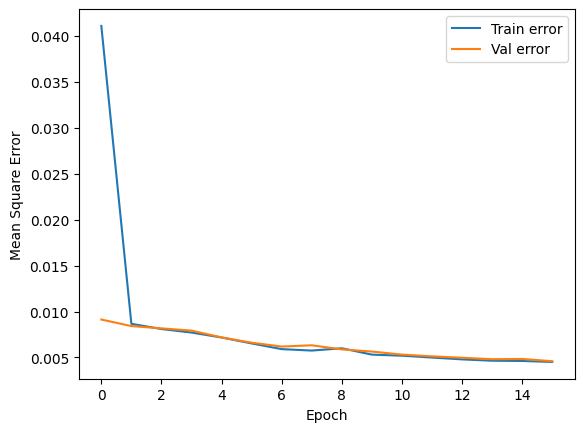

In [100]:
plt.figure()
plt.plot(hist['epoch'], hist['loss'], label='Train error')
plt.plot(hist['epoch'], hist['val_loss'], label='Val error')
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend()

plt.legend()

In [101]:
def denormalize(predictions):
    for col in INPUT_COLS:
        min, max = MIN_MAX_COLS_VALUES[col]
        predictions[col] = predictions[col] * (max - min) + min

    return predictions

5/5 [==============================] - 0s 14ms/step


C:\Users\gabri\AppData\Local\Temp\ipykernel_18032\4255147050.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions[col] = predictions[col] * (max - min) + min


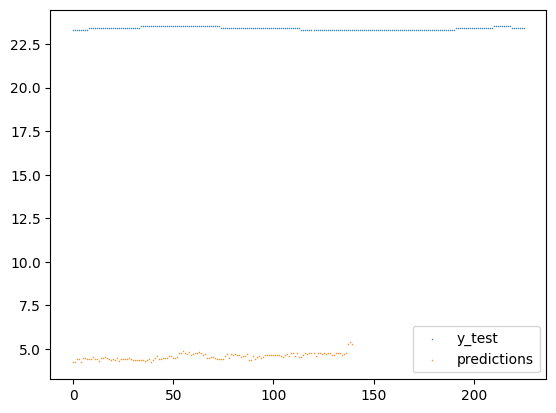

8/8 [==============================] - 0s 6ms/step


C:\Users\gabri\AppData\Local\Temp\ipykernel_18032\4255147050.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions[col] = predictions[col] * (max - min) + min


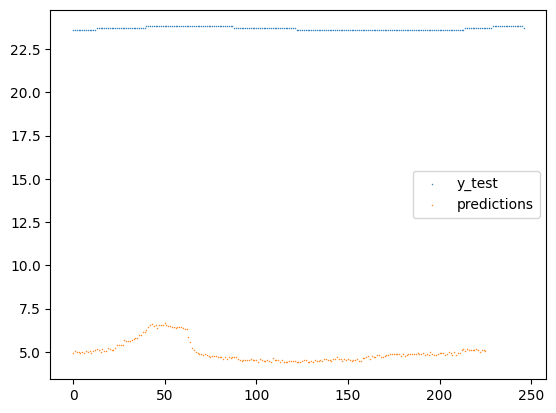

8/8 [==============================] - 0s 4ms/step


C:\Users\gabri\AppData\Local\Temp\ipykernel_18032\4255147050.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions[col] = predictions[col] * (max - min) + min


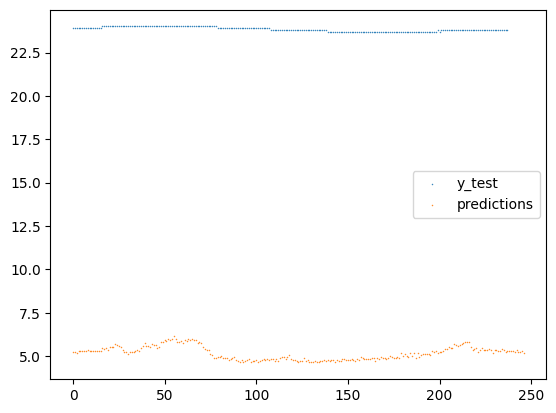

8/8 [==============================] - 0s 5ms/step


C:\Users\gabri\AppData\Local\Temp\ipykernel_18032\4255147050.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions[col] = predictions[col] * (max - min) + min


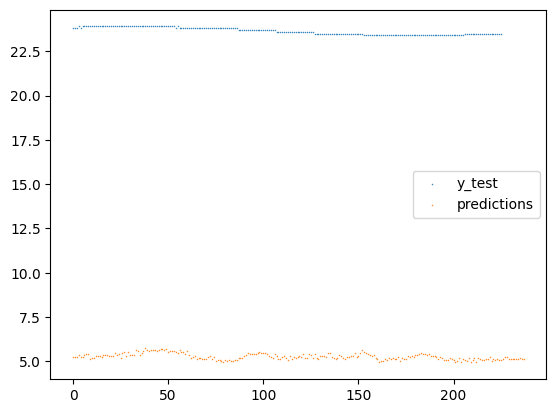

8/8 [==============================] - 0s 6ms/step


C:\Users\gabri\AppData\Local\Temp\ipykernel_18032\4255147050.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions[col] = predictions[col] * (max - min) + min


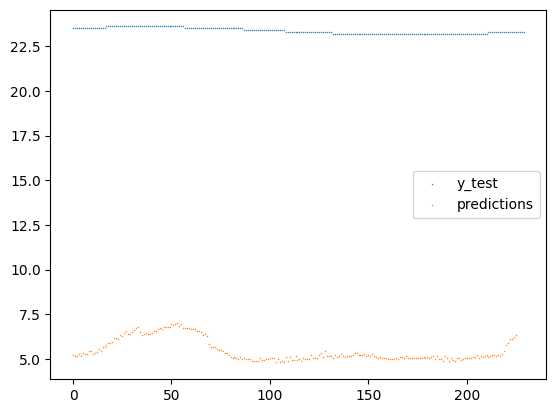

In [105]:
rolling_win = test_val.groupby(pd.Grouper(freq="24H", key="ts"))
group_keys = list(rolling_win.groups.keys())
num_checks = 5

for (_, group), (index, _) in zip(rolling_win, enumerate(group_keys)):
    if index == num_checks:
        break

    if len(group) == 0 or index == len(group_keys) - 1:
        continue

    try:
        y_test = rolling_win.get_group(name = group_keys[index + 1])

        X_test = pd.DataFrame(group[INPUT_COLS])
        predictions = pd.DataFrame(model.predict(X_test), columns=INPUT_COLS)

        predictions = denormalize(predictions)
        y_test = denormalize(y_test)

        plt.figure()
        plt.scatter(range(len(y_test["t_L_cal"])), y_test["t_L_cal"], linewidths=0.7, marker=".", s=0.5)
        plt.scatter(range(len(predictions["t_L_cal"])), predictions["t_L_cal"], linewidths=0.7, marker=".", s=0.5)
        plt.legend(["y_test", "predictions"])
        plt.show()
    except KeyError:
        continue


In [15]:
model.save("./ann_model", overwrite=True)

INFO:tensorflow:Assets written to: ./ann_model\assets


INFO:tensorflow:Assets written to: ./ann_model\assets
